# 0. Description and Overview

This model is a Proof of Concept evaluating output & performance of a Neural Network (NN) for small-sized insurance company.


# 1. Load Libraries

In [1]:
# Import libraries for data processing.
import numpy as np
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore')

# Import Tensorflow and Keras Libraries.
import tensorflow
from tensorflow.python.keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import Adam

# Import sklearn libraries for data processing.
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# Install and import Pycaret library for transformation and classification.
# !pip install pycaret
from pycaret.classification import *

In [3]:
# Installing the latest recent version of skopt directly from Github
# !pip install scikit-optimize

# Install and import Scikit Optimize library for Bayesian optimization using Gaussian Processes
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective
from skopt import dump, load

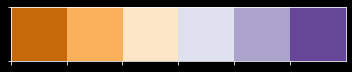

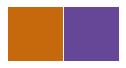

In [4]:
# Import libraries for visualization and set default values.
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette("PuOr"))
pal = sns.color_palette('PuOr', 6)
pal.as_hex()
plt.style.use(['seaborn'])
sns_colors = ["#c6690c", "#664697"]
sns.set_palette(sns_colors)
sns.palplot(sns.color_palette(sns_colors))

# 2. Load Dataset

In [7]:
# Load Dataset.
url = 'https://raw.githubusercontent.com/aliagowani/Deep_Learning_Customer_Classification/master/Data_Insurance_TGI.csv'
dataset = pd.read_csv(url)

In [8]:
# Check shape of dataset and view first 10 observations.
print(dataset.shape)
dataset.head(10)

(713, 30)


,Customer_ID,Gender,Referrer,State,PaidFullPremiumBefore,BecameCust,DurationAsCust,Accident/Health_(P)_Duration,Accident/Health_(P)_Amount,Builders_Risk_(P)_Duration,...,Life_(P)_Amount,Motorcycle_Duration,Motorcycle_Amount,Private_Passenger_Auto_Duration,Private_Passenger_Auto_Amount,Umbrella_(P)_Duration,Umbrella_(P)_Amount,Total_Duration,Total_Amount,StillCustomer
0,786258,M,None,TX,1,1,48,0,0.0,0,...,0.0,0,0,12,6087.15,0,0,60,11011.15,1
1,786063,M,None,TX,1,1,59,0,0.0,0,...,0.0,0,0,0,0.00,0,0,48,4803.00,1
2,786101,M,None,TX,1,1,51,0,0.0,0,...,0.0,0,0,51,15282.00,0,0,75,17954.00,1
3,786217,M,None,TX,1,1,48,0,0.0,0,...,0.0,0,0,48,40597.26,0,0,95,54403.26,1
4,786642,F,None,TX,1,1,47,0,0.0,0,...,0.0,0,0,12,888.00,0,0,59,3003.00,1
5,786514,M,None,TX,1,1,36,0,0.0,0,...,0.0,0,0,30,5535.91,0,0,66,8006.91,1
6,786722,F,None,TX,1,1,48,0,0.0,0,...,0.0,0,0,0,0.00,0,0,48,7005.00,1
7,786546,M,None,TX,1,1,53,0,0.0,0,...,0.0,0,0,24,2988.40,0,0,36,7583.68,1
8,786410,M,None,TX,0,1,24,0,0.0,0,...,0.0,0,0,24,11904.62,0,0,24,11904.62,0
9,786204,M,Sam,TX,1,1,48,0,0.0,0,...,0.0,0,0,48,17950.77,0,0,96,23670.52,0


# 3. Explorator Data Analysis (EDA)

In [1]:
# Describe the features in the dataset, such as, count, mean, standard deviation, min, max, etc.
dataset.describe().round(2)

NameError: name 'dataset' is not defined

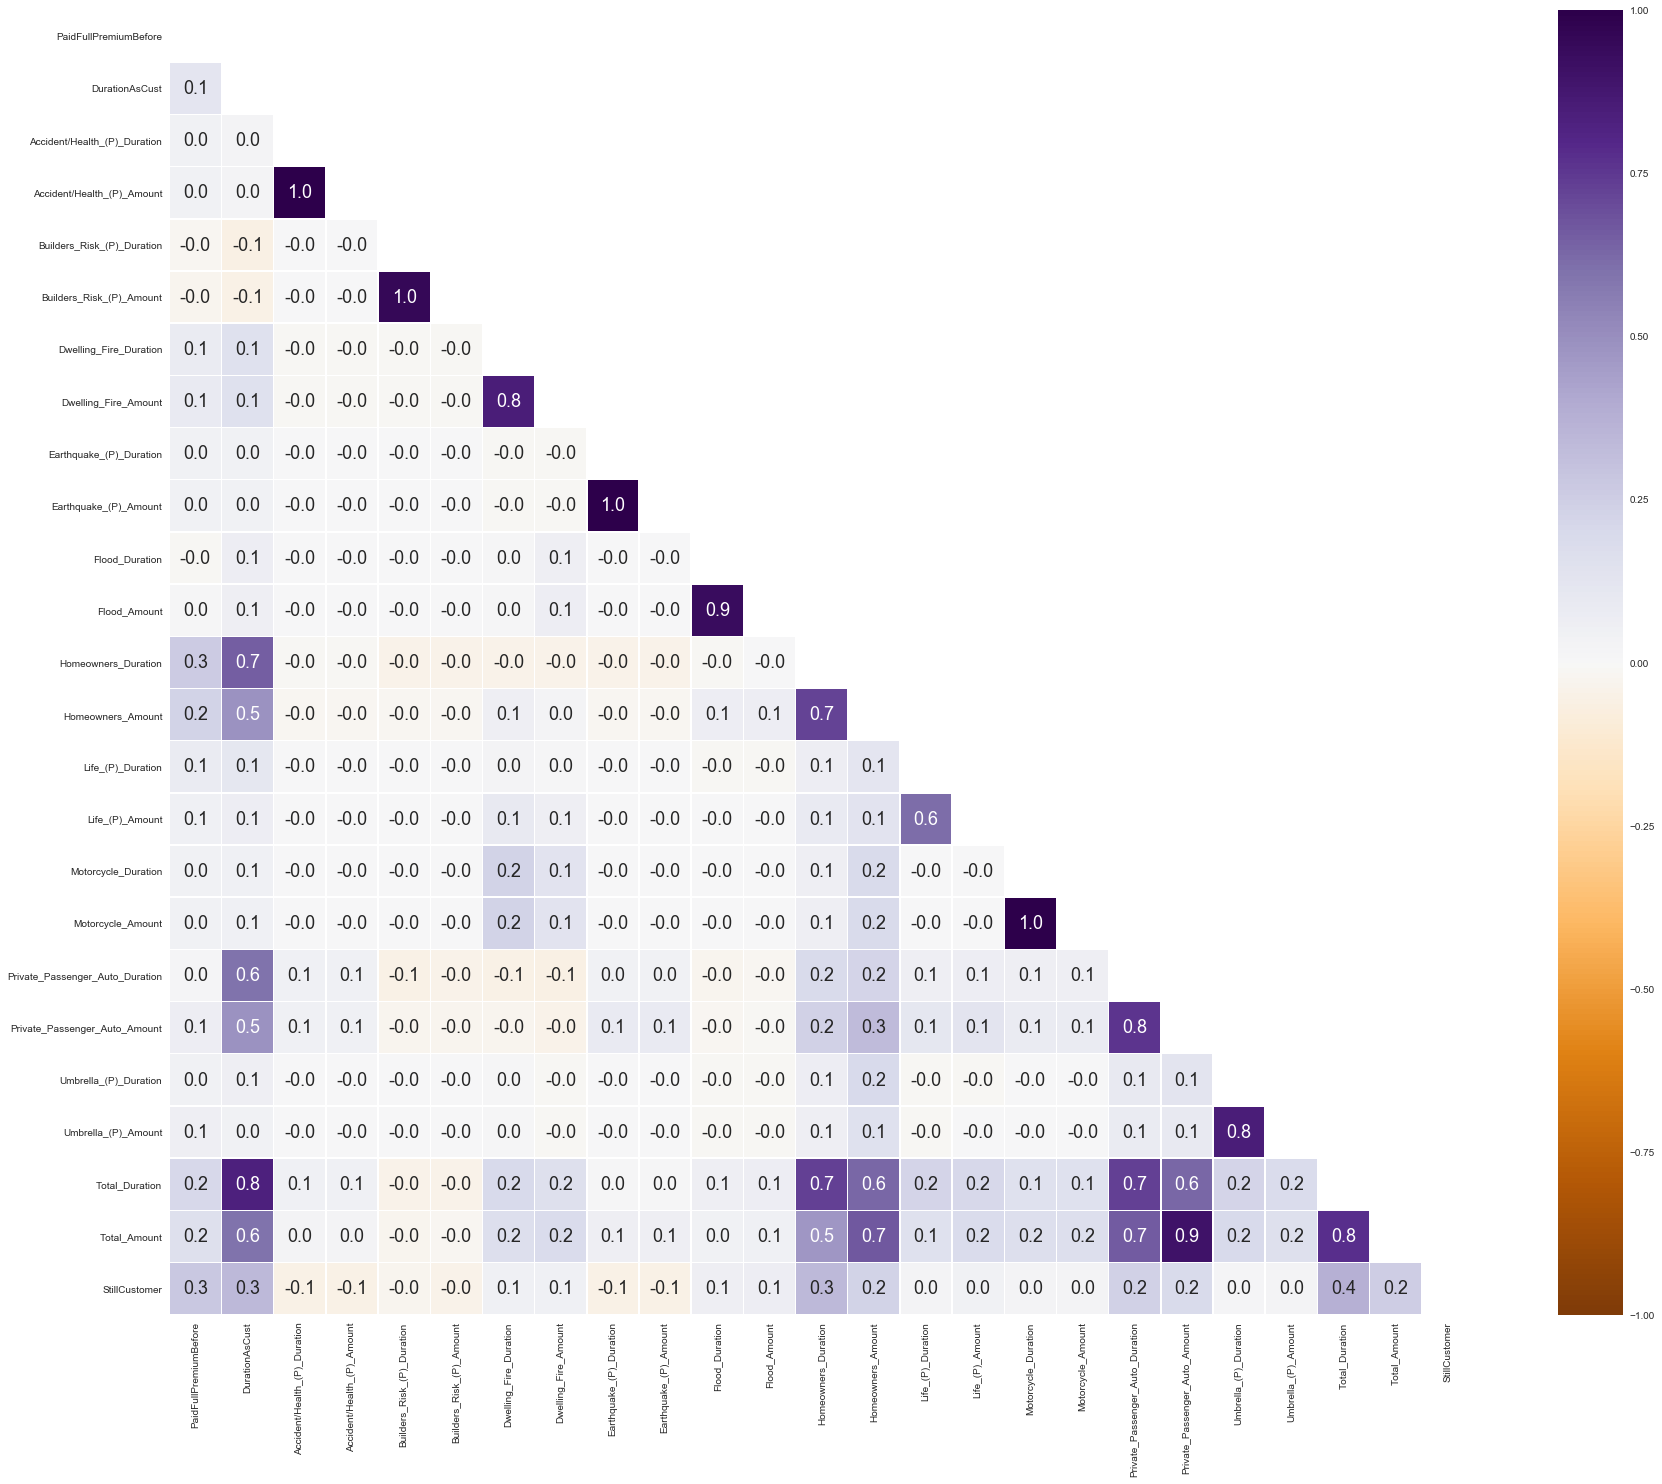

In [8]:
# Create a correlation for the dataset.
dataset_corr = dataset.corr().round(4)

# Drop Customer ID and Became Customer from correlation dataset.
dataset_corr = dataset_corr.drop(["Customer_ID","BecameCust"], axis=1)
dataset_corr = dataset_corr.drop(["Customer_ID","BecameCust"], axis=0)

# Create a correlation matrix. Only bottom left corner valued. 
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center = 0, vmin=-1, square=True, cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 18}, fmt='.1f', )
plt.show()

Not a Customer:  265
Still a Customer:  448
Total:  713



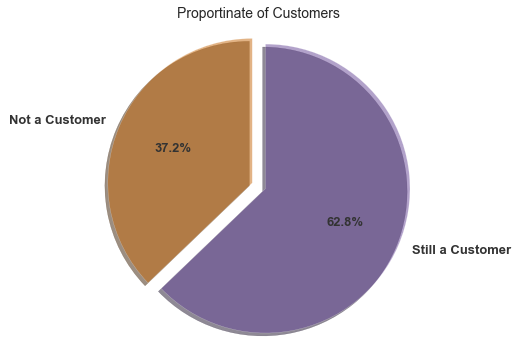

In [9]:
# Count those who are still a customer and not a customer.
not_customer = dataset.StillCustomer[dataset['StillCustomer'] == 0].count()
still_customer = dataset.StillCustomer[dataset['StillCustomer'] == 1].count()
print('Not a Customer: ', not_customer)
print('Still a Customer: ', still_customer)
print('Total: ', not_customer + still_customer)
print()

# Create a plot to visualize the proportionate customers who are still a customer versus not a customer
with sns.axes_style("whitegrid"):
    labels = 'Not a Customer', 'Still a Customer'
    sizes = [dataset.StillCustomer[dataset['StillCustomer'] == 0].count(), dataset.StillCustomer[dataset['StillCustomer'] == 1].count()]
    explode = (0, 0.1)
    fig1, ax1 = plt.subplots(figsize = (9, 6))
    ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90, textprops = {'fontsize': 13, 'weight': 'bold', 'color': '#333333'}, wedgeprops={'alpha':0.5})
    ax1.axis('equal')
    plt.title('Proportinate of Customers', size = 14)
plt.show()

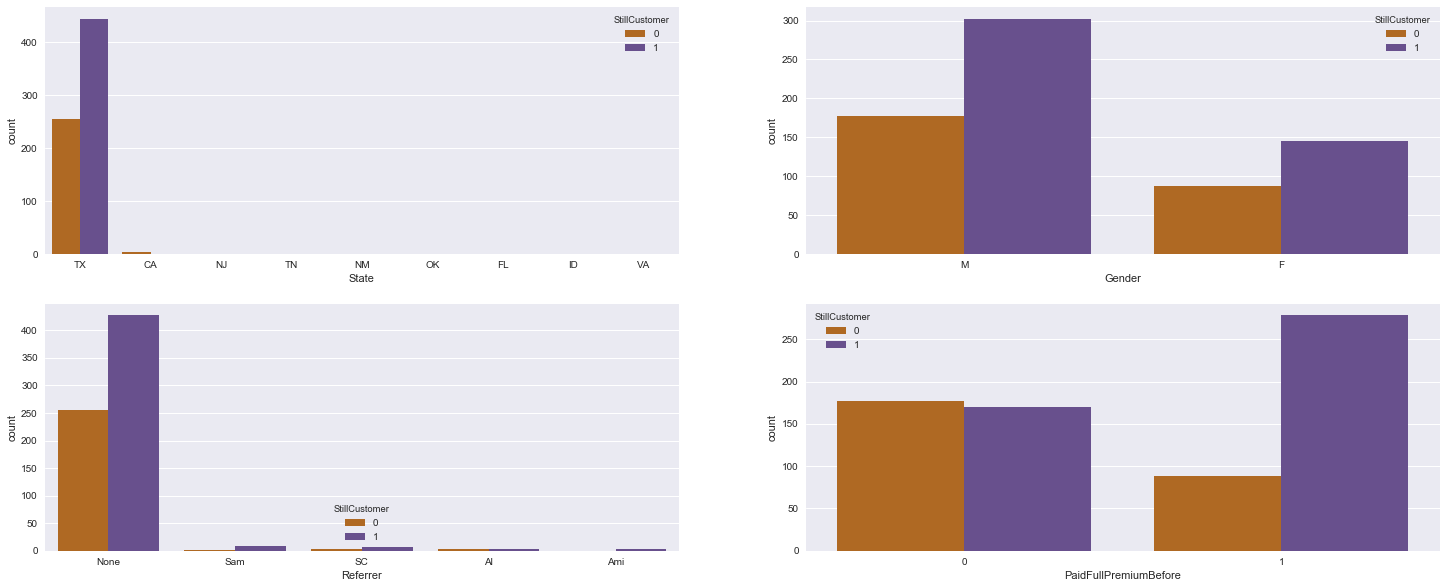

In [10]:
# Visualize label with relevant features
fig, axarr = plt.subplots(2, 2, figsize=(25, 10))
sns.countplot(x='State', hue='StillCustomer', data=dataset, ax=axarr[0][0])
sns.countplot(x='Gender', hue='StillCustomer', data=dataset, ax=axarr[0][1])
sns.countplot(x='Referrer', hue='StillCustomer', data=dataset, ax=axarr[1][0])
sns.countplot(x='PaidFullPremiumBefore', hue='StillCustomer', data=dataset, ax=axarr[1][1])

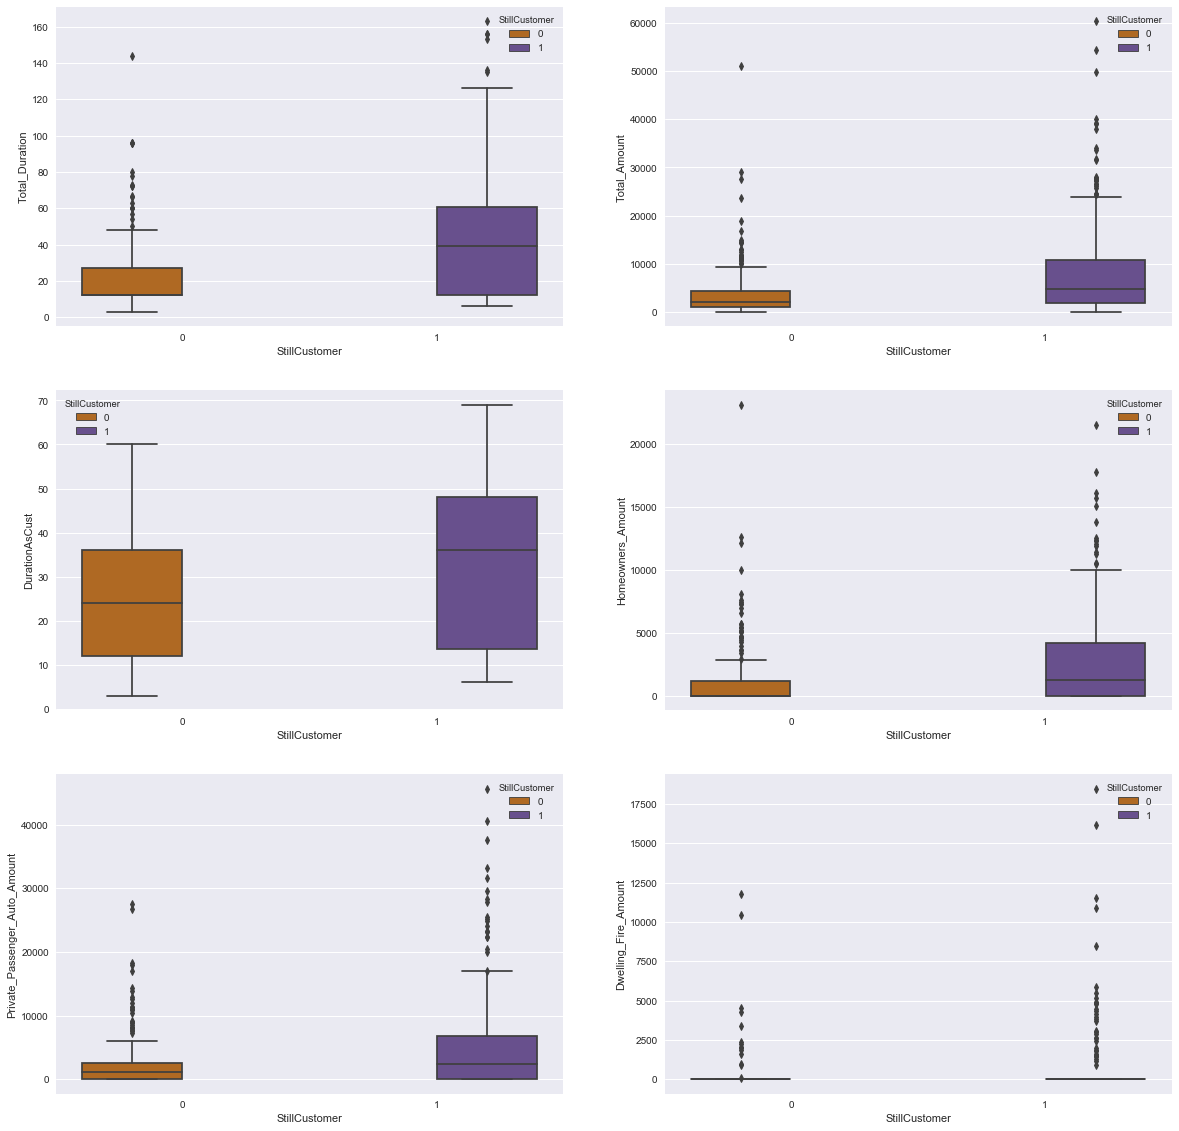

In [11]:
# Visualize box plots of numeric features and compare it with customers
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='Total_Duration', x='StillCustomer', hue='StillCustomer', data=dataset, ax=axarr[0][0])
sns.boxplot(y = 'Total_Amount', x = 'StillCustomer', hue = 'StillCustomer', data = dataset , ax = axarr[0][1])
sns.boxplot(y = 'DurationAsCust', x = 'StillCustomer', hue = 'StillCustomer', data = dataset, ax = axarr[1][0])
sns.boxplot(y = 'Homeowners_Amount', x = 'StillCustomer', hue = 'StillCustomer', data = dataset, ax = axarr[1][1])
sns.boxplot(y = 'Private_Passenger_Auto_Amount', x = 'StillCustomer', hue = 'StillCustomer', data = dataset, ax = axarr[2][0])
sns.boxplot(y='Dwelling_Fire_Amount', x='StillCustomer', hue='StillCustomer', data=dataset, ax=axarr[2][1])

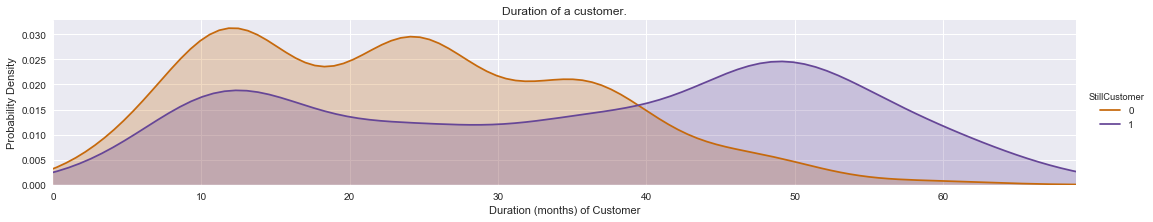

In [12]:
# Visualize the duration of a customer feature to the label
facet = sns.FacetGrid(dataset, hue = 'StillCustomer', aspect = 5)
facet.map(sns.kdeplot, 'DurationAsCust', shade = True)
facet.set(xlim = (0, dataset['DurationAsCust'].max()))
facet.add_legend()
plt.title('Duration of a customer.')
plt.ylabel('Probability Density')
plt.xlabel('Duration (months) of Customer')
plt.show()

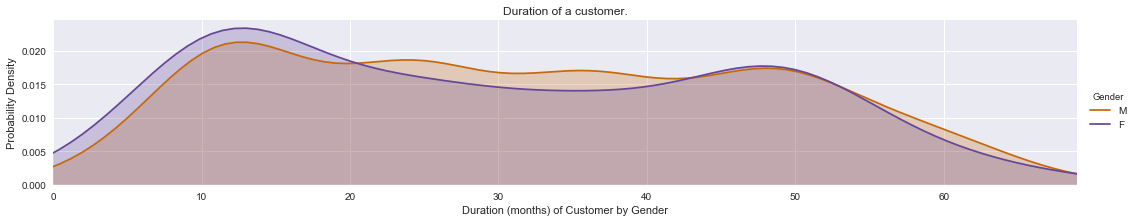

In [13]:
# Visualize the duration of a customer feature to the gender
facet = sns.FacetGrid(dataset, hue = 'Gender', aspect = 5)
facet.map(sns.kdeplot, 'DurationAsCust', shade = True)
facet.set(xlim = (0, dataset['DurationAsCust'].max()))
facet.add_legend()
plt.title('Duration of a customer.')
plt.ylabel('Probability Density')
plt.xlabel('Duration (months) of Customer by Gender')
plt.show()

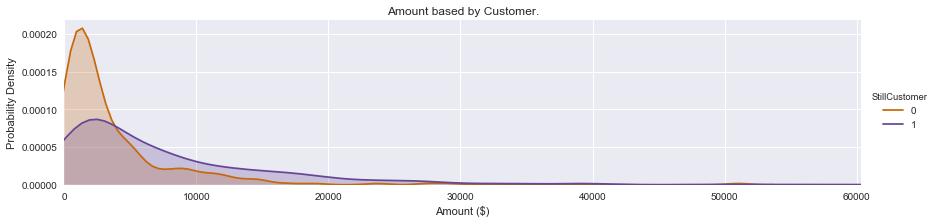

In [14]:
# Visualize the total amount feature to the label
facet = sns.FacetGrid(dataset, hue = 'StillCustomer', aspect = 4)
facet.map(sns.kdeplot, 'Total_Amount', shade = True)
facet.set(xlim = (0, dataset['Total_Amount'].max()))
facet.add_legend()
plt.title('Amount based by Customer.')
plt.ylabel('Probability Density')
plt.xlabel('Amount ($)')
plt.show()

# 4. Transform & Compare Models in PyCaret

In [15]:
# Print dataset, remove irrelevant columns and print updated dataset shape
print(dataset.shape)
data2 = dataset.drop(['Customer_ID', 'BecameCust'], axis=1)
print(data2.shape)

(713, 30)
(713, 28)


In [16]:
# Transform dataset (transform, bin and create dummy variables) and split. Note that we will 
# create a split of 95% (Train) and 5% (Test). The Test set will actually be our unseen holdout
# set for us to do our final validation. 

############################################################################
### Be sure to press Enter on your keyboard to accept the feature types. ###
############################################################################

dl_cust_class = setup(data=data2, target='StillCustomer', session_id=786, transformation=True, normalize=False, train_size=0.95, 
                   numeric_features=('Accident/Health_(P)_Duration', 'Accident/Health_(P)_Amount', 
                                     'Builders_Risk_(P)_Duration', 'Builders_Risk_(P)_Amount', 
                                     'Dwelling_Fire_Duration', 'Dwelling_Fire_Amount', 
                                     'Earthquake_(P)_Duration', 'Earthquake_(P)_Amount', 'Flood_Duration', 
                                     'Flood_Amount', 'Homeowners_Duration', 'Homeowners_Amount', 
                                     'Life_(P)_Duration', 'Life_(P)_Amount', 'Motorcycle_Duration', 
                                     'Motorcycle_Amount', 'Private_Passenger_Auto_Duration', 
                                     'Private_Passenger_Auto_Amount', 'Umbrella_(P)_Duration', 
                                     'Umbrella_(P)_Amount'), 
                   remove_outliers=False, outliers_threshold=0.05, remove_multicollinearity=False, 
                   multicollinearity_threshold=0.9, feature_selection=False, 
                   bin_numeric_features=['DurationAsCust'], feature_interaction=False)


Setup Succesfully Completed!


,Description,Value
0,session_id,786
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(713, 28)"
4,Missing Values,False
5,Numeric Features,23
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [17]:
# Allocateed various splits to appropriate variables
X_train = dl_cust_class[2]
y_train = dl_cust_class[4]
X_test = dl_cust_class[3]
y_test = dl_cust_class[5]

# Print shape of various splits
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (677, 41)
y_train (677,)
X_test (36, 41)
y_test (36,)


In [18]:
# Compare various classification models in Pycaret. Create a top model and tune it in Pycaret.
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Logistic Regression,0.7356,0.8028,0.8305,0.7683,0.797,0.4175
1,Extreme Gradient Boosting,0.7282,0.8031,0.8164,0.769,0.7903,0.403
2,CatBoost Classifier,0.7268,0.7943,0.8095,0.7698,0.7871,0.4042
3,Ridge Classifier,0.7267,0,0.8422,0.7527,0.7937,0.39
4,Gradient Boosting Classifier,0.7253,0.7961,0.8212,0.7611,0.789,0.3956
5,Linear Discriminant Analysis,0.7222,0.7975,0.8163,0.7601,0.7845,0.391
6,Ada Boost Classifier,0.7119,0.7758,0.8024,0.7567,0.7771,0.3683
7,K Neighbors Classifier,0.7089,0.7472,0.8189,0.7473,0.7794,0.3521
8,Light Gradient Boosting Machine,0.7076,0.7726,0.7906,0.7564,0.7708,0.3639
9,Random Forest Classifier,0.7062,0.7645,0.7768,0.7608,0.7668,0.3678


In [19]:
# Create the top model (Logistic Regression) with default settings
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7500,0.8553,0.8095,0.7907,0.8000,0.4668
1,0.6912,0.8068,0.7381,0.7561,0.7470,0.3509
2,0.7941,0.8344,0.8605,0.8222,0.8409,0.5497
3,0.6912,0.7423,0.7674,0.7500,0.7586,0.3302
4,0.7647,0.7609,0.8837,0.7755,0.8261,0.4672
5,0.7059,0.8028,0.8140,0.7447,0.7778,0.3455
6,0.7500,0.8130,0.8605,0.7708,0.8132,0.4388
7,0.6418,0.6924,0.7381,0.7045,0.7209,0.2217
8,0.8209,0.8486,0.8810,0.8409,0.8605,0.6108
9,0.7463,0.8714,0.9524,0.7273,0.8247,0.3938


In [20]:
# Tune the top model (Logistic Regression) with default settings
tuned_dt = tune_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7500,0.8599,0.8095,0.7907,0.8000,0.4668
1,0.6912,0.8086,0.7381,0.7561,0.7470,0.3509
2,0.8088,0.8400,0.8837,0.8261,0.8539,0.5782
3,0.7059,0.7535,0.7674,0.7674,0.7674,0.3674
4,0.7647,0.7526,0.8837,0.7755,0.8261,0.4672
5,0.7206,0.8028,0.8140,0.7609,0.7865,0.3836
6,0.7500,0.8112,0.8605,0.7708,0.8132,0.4388
7,0.6418,0.6943,0.7381,0.7045,0.7209,0.2217
8,0.8060,0.8457,0.8810,0.8222,0.8506,0.5749
9,0.7463,0.8714,0.9524,0.7273,0.8247,0.3938


 # 5. Create a baseline single-layered neural network (NN) model

In [21]:
# Create a simple (blackbox) model for comparison to the Gaussian Process model.
model = Sequential()
model.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu', name = 'input_layer', input_dim=X_train.shape[1]))
model.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu', name='hidden_layer'))
model.add(Dense(units = 1, activation='sigmoid', name="output_layer"))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

# Fit the blackbox model.
blackbox = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=.25, verbose=2)

# Evaluate the blackbox model and print accuracy
accuracy = model.evaluate(X_test,y_test)[1]
print("\n", "Accuracy Simple Neural Network Model:", accuracy, "\n")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 25)                1050      
_________________________________________________________________
hidden_layer (Dense)         (None, 20)                520       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 21        
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
_________________________________________________________________
Train on 507 samples, validate on 170 samples
Epoch 1/20
 - 1s - loss: 0.6920 - accuracy: 0.6312 - val_loss: 0.6897 - val_accuracy: 0.7000
Epoch 2/20
 - 0s - loss: 0.6882 - accuracy: 0.6765 - val_loss: 0.6863 - val_accuracy: 0.6353
Epoch 3/20
 - 0s - loss: 0.6843 - accuracy: 0.6529 - val_loss: 0.6818 - val_accuracy: 0.6353
Epoch 4/20
 - 0s - loss: 0.6795 - accuracy: 0.6686 - val_

# 6. Define Bayesian Optimization Gaussian Process

In [22]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

# Declare and instantiate variables
COUNT = 0
time_list = []

# Enable class weights if you have a unbalanced dataset
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weights = dict(enumerate(class_weights))

# Create search parameters using "dim_" short for dimension. The search will take place across nearly every parameter in the keras model. This will include: Number of Layers, Number of Nodes per layer, Learning Rate & Weight Decay for the Adam Optimizer, activation functions, batch size and Dropout rate.
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_input_nodes = Integer(low=1, high=512, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid', 'tanh', 'selu', 'elu'], name='activation')
dim_batch_size = Integer(low=1, high=256, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2, prior='uniform', name="adam_decay")
dim_dropout_rate = Real(low=0.0,high=0.5, prior='uniform', name="dropout_rate")

# Establish the variables in the deminsions variable.
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay,
              dim_dropout_rate
             ]

In [23]:
# Declare the initial value for each variable.
default_parameters = [1e-3, 1, 512, 13, 'relu', 64, 1e-3, 0.1]

In [24]:
# Define the create_model to go through various combinations of parameters.
def create_model(learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation, adam_decay, dropout_rate):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes,
                    input_dim=X_train.shape[1],
                    activation=activation
                   ))
    model.add(Dropout(dropout_rate))
    
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
        model.add(Dropout(dropout_rate))
        
    #add our classification layer.
    model.add(Dense(1,activation='sigmoid'))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay=adam_decay)
    model.compile(optimizer=adam, loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

In [25]:
# Define the arguments for the dimensions including earlyStopping for epochs.
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation, batch_size, adam_decay, dropout_rate):

    # Create a model template.            
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay,
                         dropout_rate=dropout_rate
                        )
    
    # Define earlyStopping to limit epochs
    earlyStopping = [keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose=0), keras.callbacks.ModelCheckpoint(filepath = 'bestModel.hdf5', monitor = 'val_loss', save_best_only = True)]

    # Initiate start time to track duration of each model.
    start = time.time()

    # Set random seet for tensorflow model.
    tensorflow.random.set_seed(786)

    # Establish a blackbox model to fit. Note: verbose is set to 0 to limit memory consumption when executing search.
    blackbox = model.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        batch_size=batch_size,
                        validation_split=0.25,
                        callbacks=earlyStopping,
                        #class_weight=class_weights,
                        shuffle=False,
                        verbose=0
                        )
    # Returns the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_accuracy'][-1]

    # Capture end time for the duration of each model.
    end = time.time()

    # Define counter using COUNT variable.
    def increment():
        global COUNT
        COUNT = COUNT+1
    increment()

    # Define time_list to keep track of duration for each model.
    def time_list():
        global time_list
        time_list.append(end-start)
    time_list()

    # Print the n_call, duration and accuracy for each model.
    print("n_call:", COUNT)
    print("Time (seconds):", round((end - start),2))
    print("Accuracy: {0:.2%}".format(accuracy))
    print("")

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
    K.clear_session()
    tensorflow.compat.v1.get_default_graph()
    tensorflow.compat.v1.reset_default_graph()
    tensorflow.keras.backend.clear_session()

    return - accuracy

# 7. Execute Bayesian Optimization Search

In [26]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

In [27]:
# Execute the Bayesian optimization using Gaussian Processes
gp_result = gp_minimize(func=fitness,
                            dimensions = dimensions,
                            n_calls = 40,
                            #noise = 'guassian',
                            n_jobs = -1,
                            kappa = 2.96,
                            random_state = 786,
                            acq_func = 'EI', # Expected Improvement.
                            x0 = default_parameters)

# Dump model into a pickle file for future reference. 
# dump(gp_result, 'gp_result.pkl')

n_call: 1
Time (seconds): 3.93
Accuracy: 77.06%

n_call: 2
Time (seconds): 3.13
Accuracy: 61.18%

n_call: 3
Time (seconds): 5.52
Accuracy: 61.18%

n_call: 4
Time (seconds): 3.37
Accuracy: 74.12%

n_call: 5
Time (seconds): 7.22
Accuracy: 74.12%

n_call: 6
Time (seconds): 5.05
Accuracy: 73.53%

n_call: 7
Time (seconds): 3.4
Accuracy: 61.18%

n_call: 8
Time (seconds): 6.98
Accuracy: 74.12%

n_call: 9
Time (seconds): 3.75
Accuracy: 71.76%

n_call: 10
Time (seconds): 10.4
Accuracy: 73.53%

n_call: 11
Time (seconds): 5.21
Accuracy: 67.06%

n_call: 12
Time (seconds): 3.34
Accuracy: 61.18%

n_call: 13
Time (seconds): 15.46
Accuracy: 61.18%

n_call: 14
Time (seconds): 16.86
Accuracy: 78.24%

n_call: 15
Time (seconds): 2.38
Accuracy: 67.06%

n_call: 16
Time (seconds): 3.23
Accuracy: 75.29%

n_call: 17
Time (seconds): 5.65
Accuracy: 74.71%

n_call: 18
Time (seconds): 4.36
Accuracy: 71.76%

n_call: 19
Time (seconds): 3.31
Accuracy: 61.18%

n_call: 20
Time (seconds): 7.61
Accuracy: 72.94%

n_call: 

In [28]:
# Print the accuary of the best model.
print("Best Model Accuracy: " + str(round(gp_result.fun * -100, 2)) + "%.")

Best Model Accuracy: 78.24%.


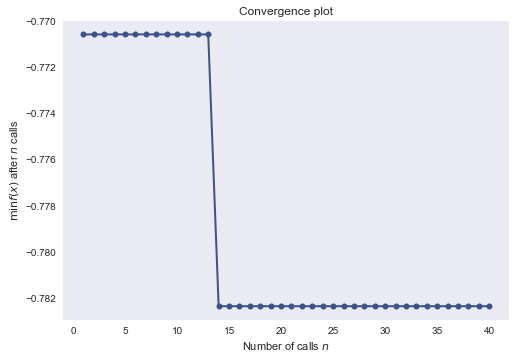

In [29]:
# Plot SKOPT convergence traces.
_ = plot_convergence(gp_result)

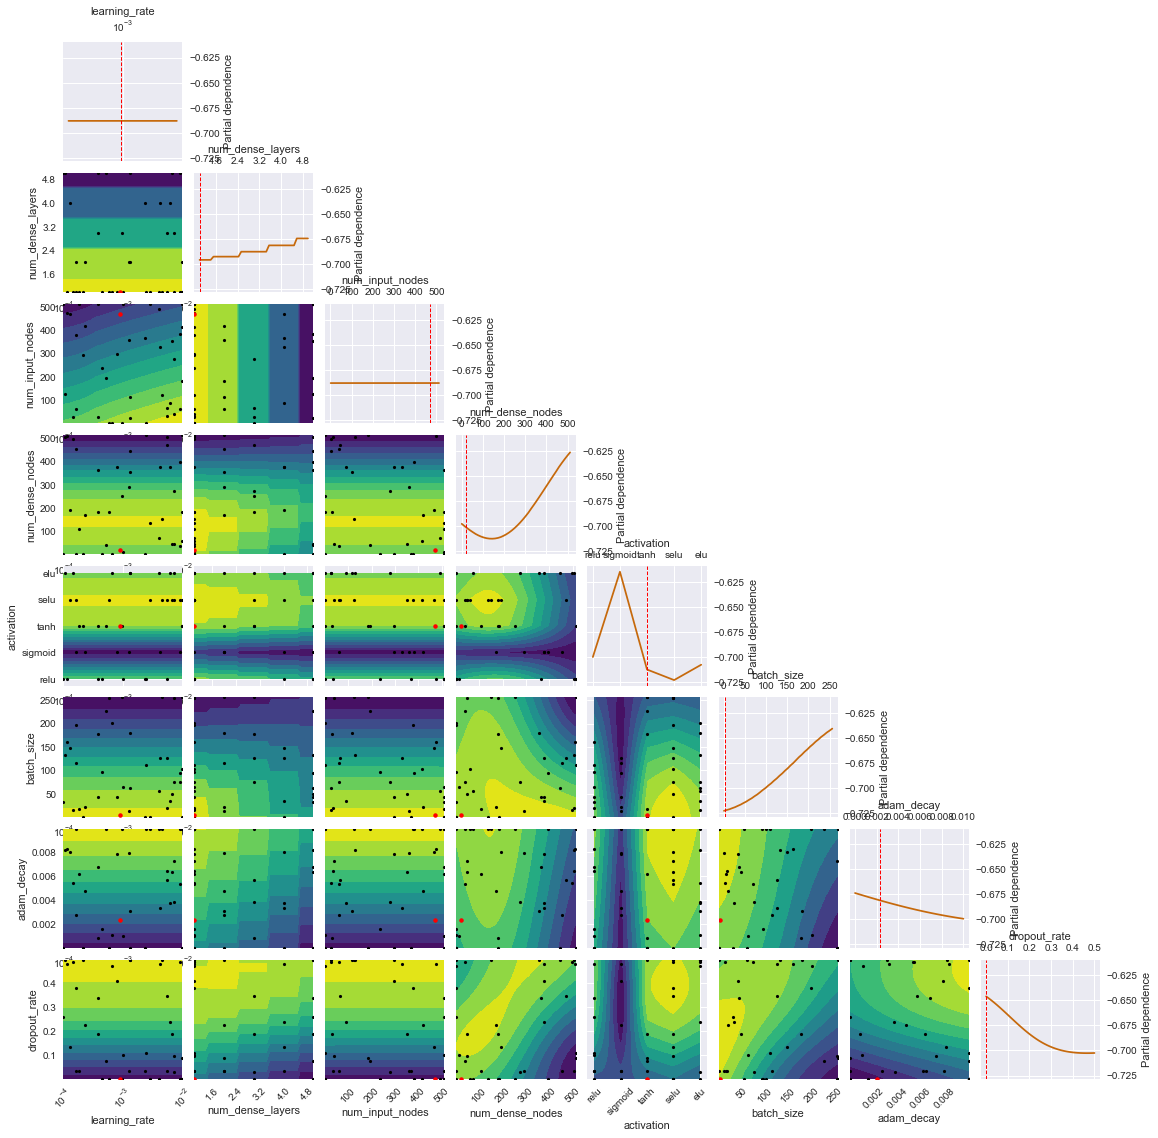

In [30]:
# Show pairwise dependence plot of the objective function.
_ = plot_objective(gp_result)

In [31]:
# Create a dataframe of the results.
df_gp_result = pd.concat([pd.DataFrame(gp_result.x_iters, 
                    columns = ["learning rate",
                    "hidden layers","input layer nodes","hidden layer nodes", "activation function","batch size", "adam learning rate decay","dropout rate"]),
                    (pd.Series(gp_result.func_vals*-100, name="accuracy"))], axis=1)

# Add duration of each model into the dataframe.
time_list = pd.DataFrame(time_list)

# Round the duration of each model.
df_gp_result['time (seconds)'] = round(time_list,2)

# Sort the models by accuracy (descending order).
df_gp_result_saved = df_gp_result.sort_values(by='accuracy', ascending=False)

In [32]:
# Display the top 5 most accurate models
df_gp_result_saved.head()

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,dropout rate,accuracy,time (seconds)
13,0.000918,1,470,22,tanh,4,0.002282,0.000000,78.235292,16.86
34,0.000182,1,512,108,tanh,17,0.006174,0.032538,77.647060,12.80
24,0.002831,1,512,137,selu,1,0.010000,0.000000,77.647060,64.10
0,0.001000,1,512,13,relu,64,0.001000,0.100000,77.058822,3.93
23,0.007351,1,39,46,selu,254,0.007238,0.095014,77.058822,2.86


In [0]:
# Save and read data into a CSV file for future reference.
# df_gp_result_saved.to_csv('df_gp_result_saved.csv', index=True, index_label='index', header=True)

# Load the df_gp_result_saved.csv if returning
# df_gp_result_saved = pd.read_csv('df_gp_result_saved.csv', index_col=0, header=0)

# 8. Create the selected Deep Learning model & validate

In [33]:
# Identify the best model to select that meets our criteria and input the index number from df_gp_result_saved
gp_model_parameters = gp_result.x_iters[13]
df_gp_result_saved.loc[[13]]

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,dropout rate,accuracy,time (seconds)
13,0.000918,1,470,22,tanh,4,0.002282,0.0,78.235292,16.86


In [34]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

# Create a model based on the best model we have selected.
gp_model = create_model(gp_model_parameters[0],  gp_model_parameters[1], 
                        gp_model_parameters[2], gp_model_parameters[3], 
                        gp_model_parameters[4], gp_model_parameters[5], 
                        gp_model_parameters[6])

# Display our final model. 
gp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 470)               19740     
_________________________________________________________________
dropout_1 (Dropout)          (None, 470)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 22)                10362     
_________________________________________________________________
dropout_2 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 23        
Total params: 30,125
Trainable params: 30,125
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Select optimizer then compile and fit the selected model.
adam = Adam(lr=gp_model_parameters[0], decay=gp_model_parameters[6])
gp_model.compile(optimizer=adam, loss='binary_crossentropy',
                 metrics=['accuracy'])

# Create earlyStopping call back.
earlyStopping = [keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0), 
                 keras.callbacks.ModelCheckpoint(filepath='bestModel.hdf5', 
                                                 monitor='val_loss', save_best_only=True)]

# Fit the model using the best selected parameters
history = gp_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                       epochs=20, 
                       callbacks=earlyStopping, 
                       batch_size=gp_model_parameters[5], 
                       verbose=2)

Train on 677 samples, validate on 36 samples
Epoch 1/20
 - 2s - loss: 0.5690 - accuracy: 0.7031 - val_loss: 0.5016 - val_accuracy: 0.7500
Epoch 2/20
 - 1s - loss: 0.5212 - accuracy: 0.7267 - val_loss: 0.4649 - val_accuracy: 0.7778
Epoch 3/20
 - 1s - loss: 0.5025 - accuracy: 0.7297 - val_loss: 0.4656 - val_accuracy: 0.7778


In [36]:
# Evaluate the selected model.
_, train_acc = gp_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = gp_model.evaluate(X_test, y_test, verbose=0)

print("\n", 'Train: %.3f, Test: %.3f' % (train_acc, test_acc), "\n")


 Train: 0.758, Test: 0.778 



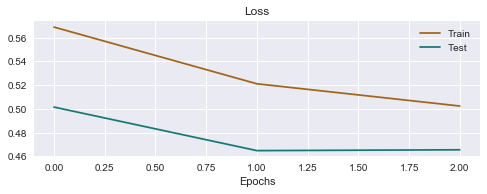

In [37]:
# Plot Loss during training on selected model.
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train', color='#a16518')
plt.plot(history.history['val_loss'], label='Test', color='#167a72')
plt.xlabel('Epochs')
plt.legend()
plt.show()

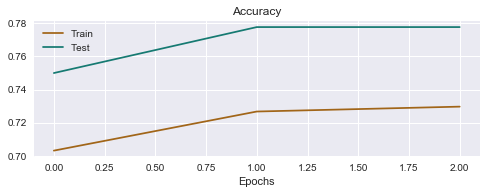

In [38]:
# Plot Accuracy during training on selected model.
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train', color='#a16518')
plt.plot(history.history['val_accuracy'], label='Test', color='#167a72')
plt.xlabel('Epochs')
plt.legend()
plt.show()

[Text(0, 0.5, 'Still Customer'), Text(0, 1.5, 'Not Customer')]

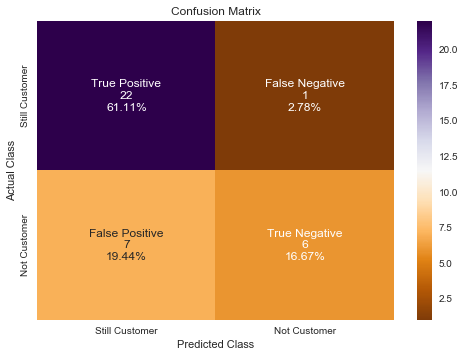

In [39]:
# Create Confusion Matrix for Visualization

# Create classes to compare
y_pred_classes = gp_model.predict_classes(X_test)
y_pred_probs = gp_model.predict(X_test)

# Create a confusion matrix for us to visualize
cf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[1, 0])

# Modify the names and create counts and percentages 
group_names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Visualize the heatmap (confusion matrix)
ax = plt.subplot()
plt.rcParams["axes.labelsize"] = 12
plt.rcParams.update({'font.size': 12})
sns.heatmap(cf_matrix, annot=labels, fmt='', ax=ax, annot_kws={'fontsize':12}, cmap='PuOr')

# labels, title and ticks
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Still Customer', 'Not Customer'])
ax.yaxis.set_ticklabels(['Still Customer', 'Not Customer'], va='center')

# 9. Sources and Refernces

##### Learn: Learn: Machine learning in Python - scikit-learn 0.16.1 documentation. (n.d.). Retrieved June 11, 2020, from https://scikit-learn.org/

##### Pycaret. (2020, May 11). Retrieved June 11, 2020, from https://pycaret.org/

##### TensorFlow. (n.d.). Retrieved June 12, 2020, from https://www.tensorflow.org/

##### Team, K. (n.d.). Simple. Flexible. Powerful. Retrieved June 12, 2020, from https://keras.io/

##### Scikit Learn Optimize. (n.d.). Retrieved June 12, 2020, from https://scikit-optimize.github.io/stable/index.html

